<a href="https://colab.research.google.com/github/Williammailliw123/NTHU_NLP/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part I: Data Pre-processing

In [1]:
import pandas as pd

In [2]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2024-09-20 03:30:19--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.107.207, 74.125.196.207, 74.125.141.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.107.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.003s  

2024-09-20 03:30:19 (195 MB/s) - ‘questions-words.txt’ saved [603955/603955]



In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [4]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

questions = []
categories = []
sub_categories = []

cnt=0
cur_sub=""
for entry in data:
    if entry.startswith(':'):
        cnt+=1
        cur_sub=entry
    else:
        questions.append(entry)
        sub_categories.append(cur_sub)
        if cnt <= 5:
            categories.append("Semantic")
        else:
            categories.append("Syntactic")

In [13]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [14]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries


In [15]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [16]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
data = pd.read_csv("questions-words.csv")

In [18]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 128.1/128.1MB downloaded
The Gensim model loaded successfully!


In [19]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split()
      a = words[0].lower()
      b = words[1].lower()
      c = words[2].lower()
      d = words[3].lower()
      golds.append(d)
      if a in model and b in model and c in model:
            result_vector = model[b] - model[a] + model[c]
            similar_word = model.similar_by_vector(result_vector, topn=1)
            preds.append(similar_word[0][0])
      else:
            preds.append("UNKNOWN")
print(preds[:5])

100%|██████████| 19544/19544 [02:43<00:00, 119.46it/s]

['iraq', 'thailand', 'china', 'germany', 'bern']


In [ ]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 44.31164731085804%
Category: Syntactic, Accuracy: 27.306791569086652%
Sub-Category: capital-common-countries, Accuracy: 79.05138339920948%
Sub-Category: capital-world, Accuracy: 65.42882404951371%
Sub-Category: currency, Accuracy: 9.006928406466514%
Sub-Category: city-in-state, Accuracy: 11.795703283340089%
Sub-Category: family, Accuracy: 39.723320158102766%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 6.048387096774194%
Sub-Category: gram2-opposite, Accuracy: 6.280788177339902%
Sub-Category: gram3-comparative, Accuracy: 30.705705705705704%
Sub-Category: gram4-superlative, Accuracy: 25.49019607843137%
Sub-Category: gram5-present-participle, Accuracy: 13.446969696969695%
Sub-Category: gram6-nationality-adjective, Accuracy: 86.55409631019387%
Sub-Category: gram7-past-tense, Accuracy: 11.346153846153847%
Sub-Category: gram8-plural, Accuracy: 15.54054054054054%
Sub-Category: gram9-plural-verbs, Accuracy: 22.873563218390807%


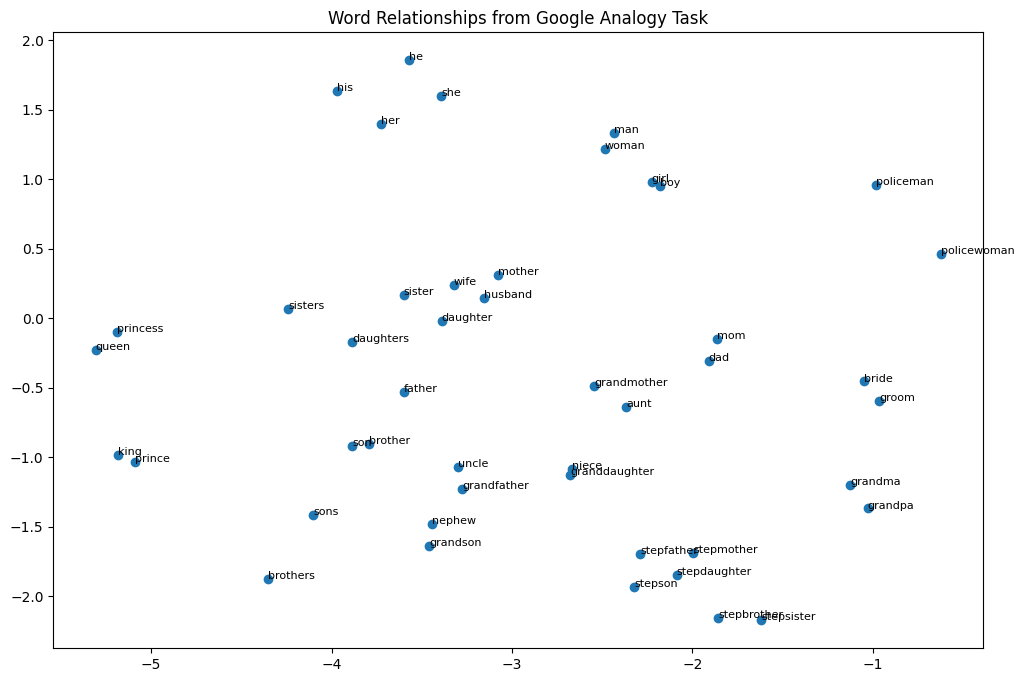

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
family_data = data[data["SubCategory"] == SUB_CATEGORY]
family_question = family_data["Question"]
words = [item for sublist in family_question for item in sublist.split()]
unique_words = list(set(words))
valid_words = [word for word in unique_words if word in model]
word_vectors = np.array([model[word] for word in valid_words])

tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(12,8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o')
for i, word in enumerate(valid_words):
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=8)

plt.title("Word Relationships from Google Analogy Task")
plt.savefig("word_relationships.png", bbox_inches="tight")
plt.show()

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd
From (redirected): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd&confirm=t&uuid=b7032202-329c-4c37-9335-8253e0985d3b
To: /content/wiki_texts_part_0.txt.gz
100% 1.51G/1.51G [00:08<00:00, 171MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG
From (redirected): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG&confirm=t&uuid=8ff08810-2aac-4719-a752-70d928617741
To: /content/w

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI
From (redirected): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI&confirm=t&uuid=419ec400-dae0-405c-956b-9c3dead6283a
To: /content/wiki_texts_part_5.txt.gz
100% 578M/578M [00:04<00:00, 127MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P
From (redirected): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P&confirm=t&uuid=b8f1bca3-cfff-486f-ac42-aec3d4ac93c6
To: /content/wik

In [ ]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [ ]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [ ]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [ ]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
output_path = "wiki_texts_sample.txt"
with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
      lines = f.readlines()
      sample_ratio = 0.2
      num_lines = len(lines)
      num_sampled_lines = int(num_lines * sample_ratio)
      sampled_lines = random.sample(lines, num_sampled_lines)
      output_file.writelines(sampled_lines)

In [ ]:
# Check the first ten lines of the sample file
!head -n 10 wiki_texts_sample.txt

david younghusband was residential architect and building contractor in ottawa ontario canada his houses typically brick construction in the arts and crafts style and featuring centre hall plan form prominent part of the residential architectural fabric in number of ottawa neighbourhoods dating from the first half of the th century in particular the glebe neighbourhood references john leaning the story of the glebe accessed september maria cook walking tour of the glebe ottawa citizen september
louis giani august january was an american wrestler he competed in the men freestyle featherweight at the summer olympics for years he was the head wrestling coach at huntingtown high school in huntington new york compiling career record of in he was inducted into the national wrestling hall of fame as distinguished member references external links
the globe investment trust plc was very large british investment trust it was listed on the london stock exchange and was constituent of the ftse ind

In [ ]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter

train_data_path = "wiki_texts_sample.txt"
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')

model = None
sentences = []
with open(train_data_path, "r", encoding="utf-8") as corpus:
  for i,sentence in enumerate(corpus):
    #Better tokenization than simply splitting words based on whitespaces
    processed_sentence = word_tokenize(sentence)
    #Remove non-English words
    processed_sentence = [word for word in processed_sentence if re.match("^[a-zA-Z]+$", word)]
    #Remove stop words
    processed_sentence = [word for word in processed_sentence if word not in stop_words]
    #Lemmatization (e.g., rocks -> rock)
    processed_sentence = [lemmatizer.lemmatize(word) for word in processed_sentence]
    #Append sentence
    sentences.append(processed_sentence)

    if (i + 1) % 200000 == 0:
      if model is None:
        #Retain the most frequent words for the dictionary by min_count
        model = Word2Vec(sentences, vector_size=100, window=5, min_count=3, sg=1, workers=4)
      else:
        model.build_vocab(sentences, update=True)
        model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)
      sentences = []
      print(f"Trained on {i + 1} lines.")
  if sentences:
    model.build_vocab(sentences, update=True)
    model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

model.save("word2vec.model")
print("Model saved successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Trained on 200000 lines.


Trained on 400000 lines.


In [ ]:
data = pd.read_csv("questions-words.csv")

In [ ]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`


plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")